In [15]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../../rule_lib')
sys.path.insert(1, '../../../../notes/1-Testing/fuzzy-test/python/')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [16]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../../tuning-results-pause-during-examples/data-cluster-pause/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        assert len(corresponding_liveInfo) == len(
            tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # convert tuningData timings into percentages
        maxTime = tuningData["Reduced"].max()
        tuningData.insert(1, "PerformancePercentage", (
            tuningData["Reduced"] / maxTime) * 100)

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

Processing ../../../tuning-results-pause-during-examples/data-cluster-pause/uniform_cube_a_2
Processing ../../../tuning-results-pause-during-examples/data-cluster-pause/uniform_cube_a_1


In [17]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(50000, 29)

In [18]:
df.describe()

avgParticlesPerCell   cutoff  domainSizeX  domainSizeY  domainSizeZ  \
count         50000.000000  50000.0      50000.0      50000.0      50000.0   
mean              0.944637      3.0         50.0         50.0         50.0   
std               0.000000      0.0          0.0          0.0          0.0   
min               0.944637      3.0         50.0         50.0         50.0   
25%               0.944637      3.0         50.0         50.0         50.0   
50%               0.944637      3.0         50.0         50.0         50.0   
75%               0.944637      3.0         50.0         50.0         50.0   
max               0.944637      3.0         50.0         50.0         50.0   

       estimatedNumNeighborInteractions   homogeneity    maxDensity  \
count                      50000.000000  50000.000000  50000.000000   
mean                       82707.152000      0.082858      0.617237   
std                         6201.057302      0.005386      0.107886   
min                        60002.000000      0.070202      0.305040   
25%                        80861.000000      0.080484      0.520800   
50%                        81969.000000      0.081997      0.654720   
75%                        82990.000000      0.083359      0.706800   
max                       109507.000000      0.106135      0.773760   

       maxParticlesPerCell  minParticlesPerCell  ...  \
count         50000.000000              50000.0  ...   
mean             22.333000                  0.0  ...   
std               2.699677                  0.0  ...   
min               8.000000                  0.0  ...   
25%              21.000000                  0.0  ...   
50%              23.000000                  0.0  ...   
75%              24.000000                  0.0  ...   
max              27.000000                  0.0  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                      50000.0                   50000.000000   
mean                          72.0                       0.321054   
std                            0.0                       0.039976   
min                           72.0                       0.216416   
25%                           72.0                       0.294550   
50%                           72.0                       0.320995   
75%                           72.0                       0.351314   
max                           72.0                       0.398774   

       particlesPerCellStdDev  rebuildFrequency     skin  threadCount  \
count            50000.000000           50000.0  50000.0  50000.00000   
mean                 0.040457              10.0      1.0     13.80000   
std                  0.001668               0.0      0.0     10.66594   
min                  0.033701              10.0      1.0      1.00000   
25%                  0.039982              10.0      1.0      4.00000   
50%                  0.040289              10.0      1.0     12.00000   
75%                  0.040569              10.0      1.0     24.00000   
max                  0.047267              10.0      1.0     28.00000   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count           50000.000000         50000.0  5.000000e+04  5.000000e+04  
mean               33.882959             1.0  1.000545e+07  9.871953e+06  
std                13.903484             0.0  4.179867e+06  4.072350e+06  
min                 9.535054             1.0  3.069750e+06  3.069750e+06  
25%                24.747903             1.0  7.209478e+06  7.141648e+06  
50%                31.099914             1.0  9.132051e+06  9.047050e+06  
75%                40.482944             1.0  1.189386e+07  1.174797e+07  
max               100.000000             1.0  3.435285e+07  3.050409e+07  

[8 rows x 25 columns]

In [19]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [20]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [21]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [22]:
# only keep rows where performance percentage is above x
dffiltered = df[df["PerformancePercentage"] >= 70]


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)


# Remove any rows where a numerical colum lies outside 3 standard deviations

X, y =dfgrouped[inputs], dfgrouped[outputs]

print(X.shape, y.shape)

(670, 6) (670, 3)


# Create Train and Test Data


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [24]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
235             0.944637     0.081911     0.63612                   23   
479             0.944637     0.083584     0.75516                   25   
603             0.944637     0.090604     0.46872                   19   
61              0.944637     0.079787     0.58032                   22   
145             0.944637     0.081013     0.73284                   24   

     particlesPerCellStdDev  threadCount    Container_DataLayout  \
235                0.040808           28  VerletClusterLists_AoS   
479                0.040579           24  VerletClusterLists_AoS   
603                0.041942           28  VerletClusterLists_AoS   
61                 0.040912           24  VerletClusterLists_AoS   
145                0.040220           12  VerletClusterLists_AoS   

                                            Traversal  Newton 3  
235  vcl_c01_balanced, vcl_c06, vcl_cluster_iteration  disabled  
479                         vcl_c01_balanced, vcl_c06  disabled  
603  vcl_c01_balanced, vcl_c06, vcl_cluster_iteration  disabled  
61                                   vcl_c01_balanced  disabled  
145                         vcl_c01_balanced, vcl_c06  disabled

In [25]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

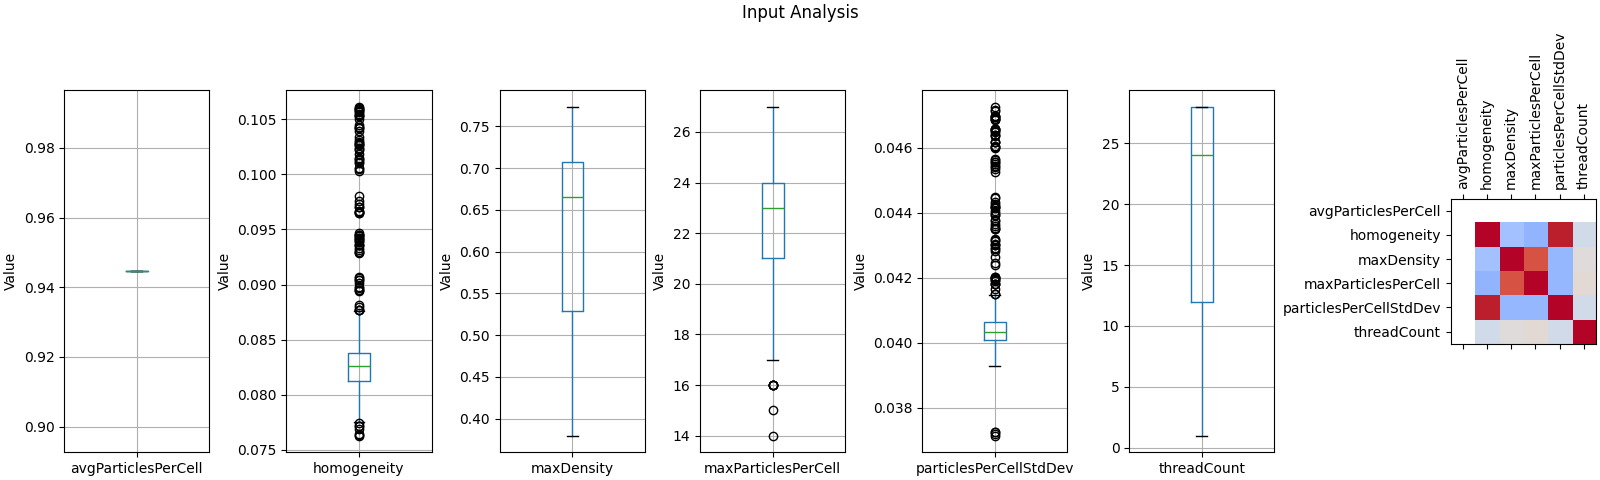

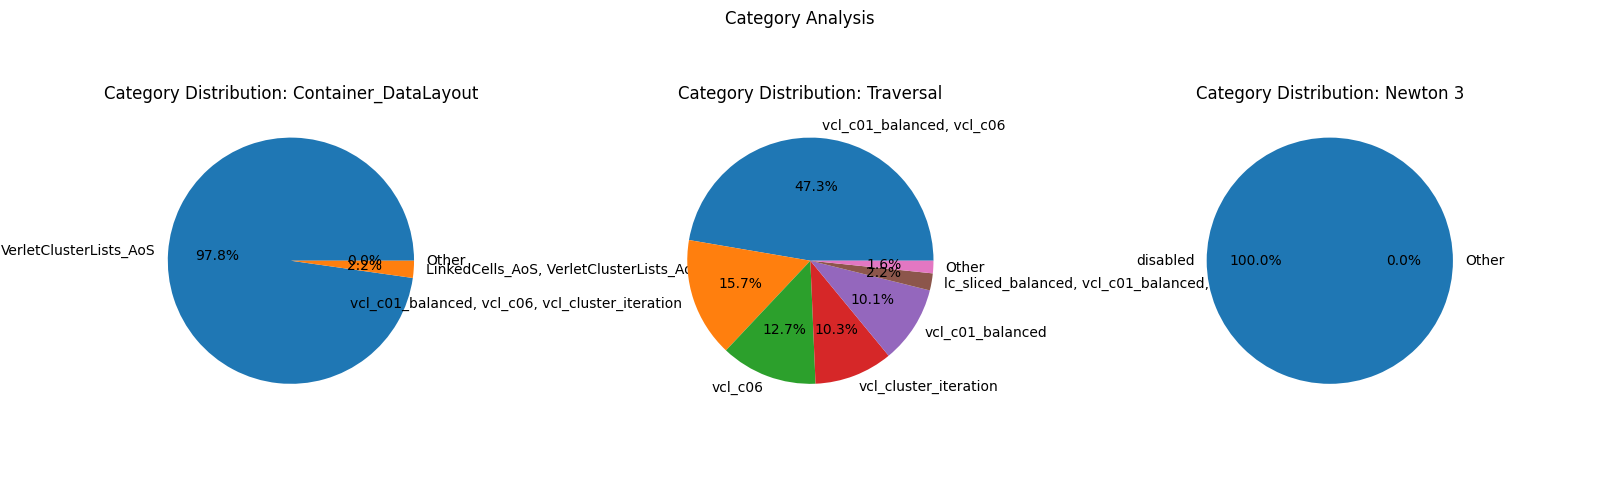

In [26]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [27]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.05,
    "Traversal": 0.05,
    "Newton 3": 0.05,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 536 samples
Number of rules 27:
	Container_DataLayout (4 rules)
	Traversal (22 rules)
	Newton 3 (1 rules)


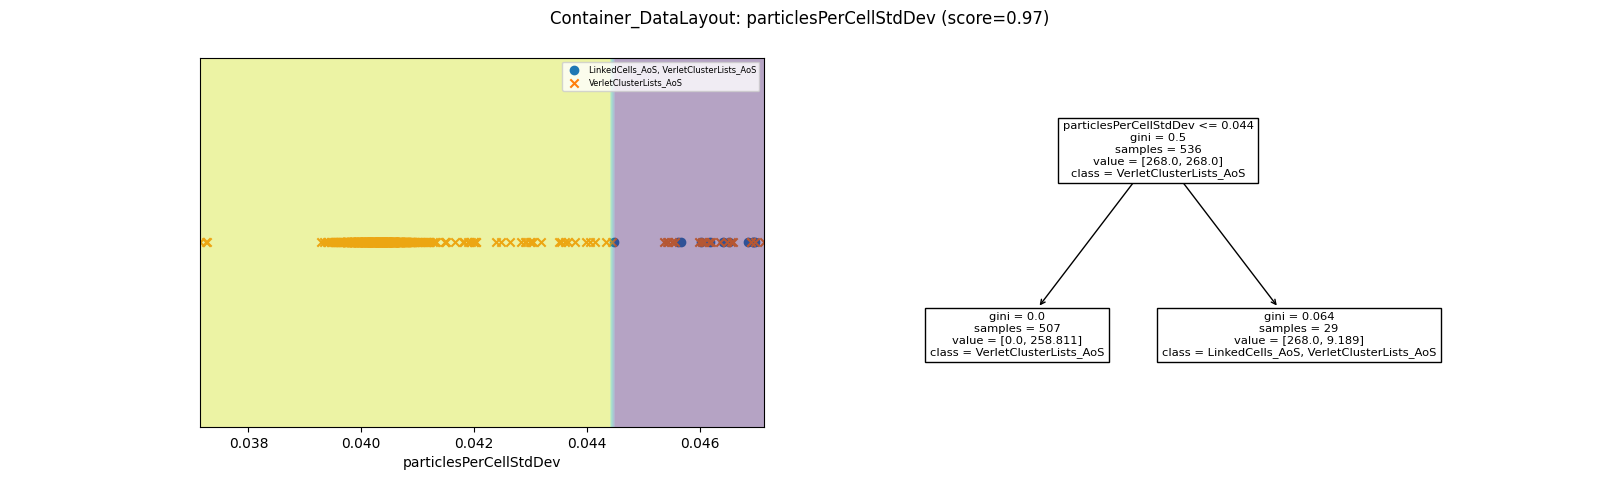

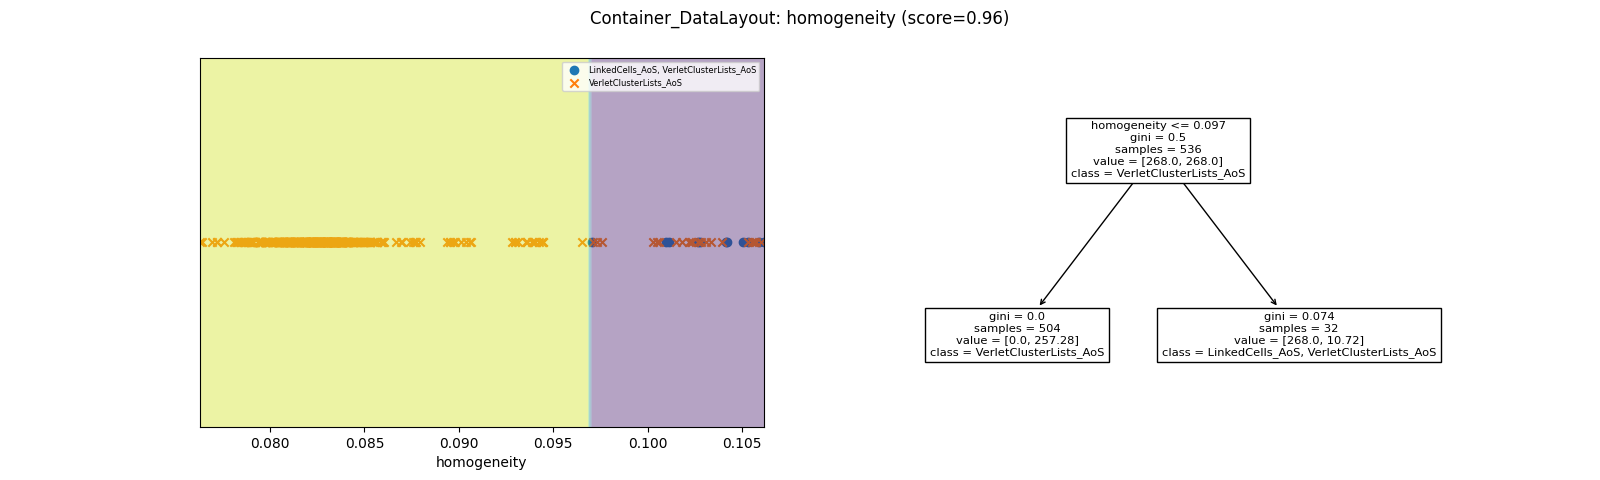

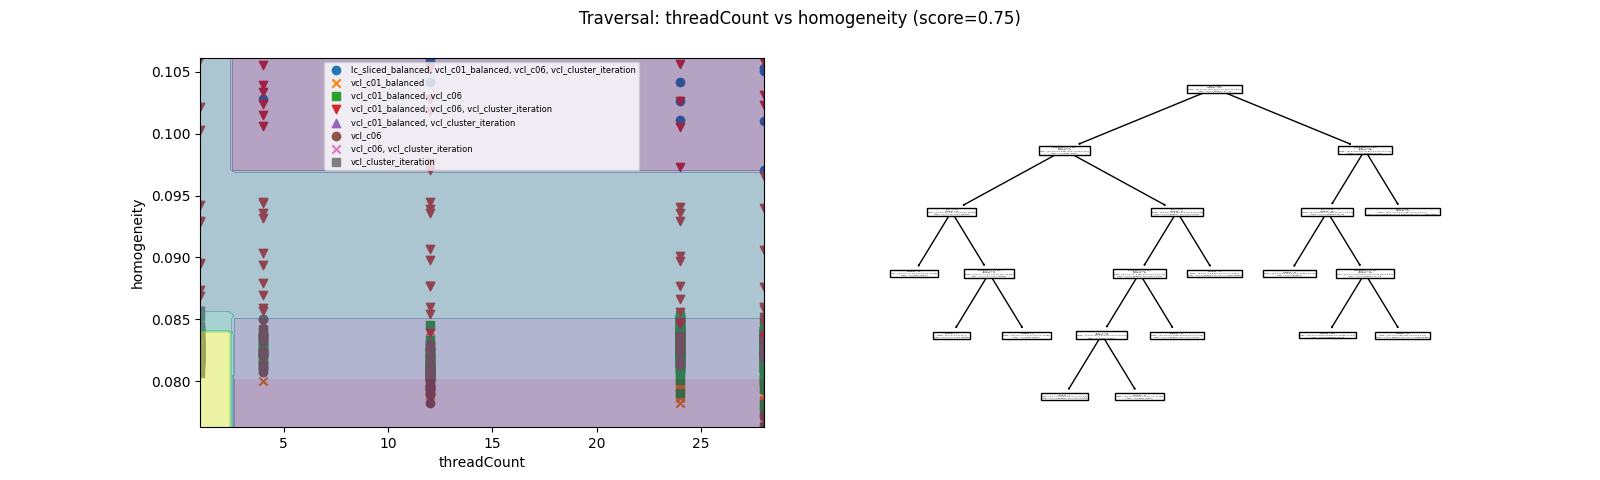

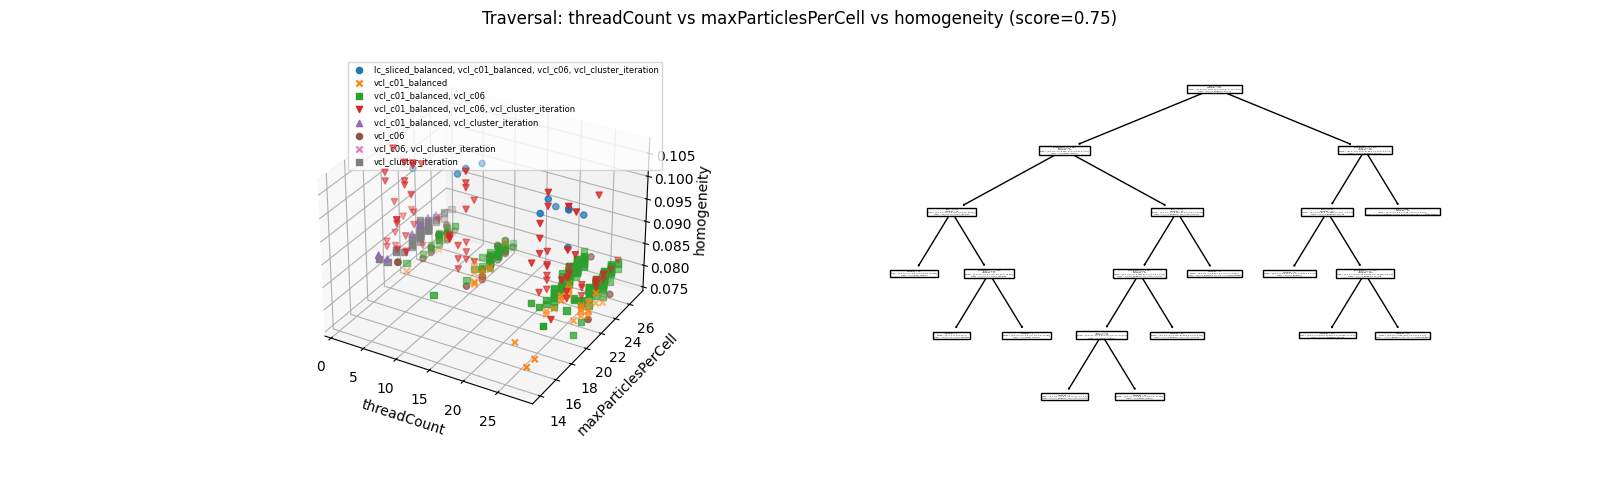

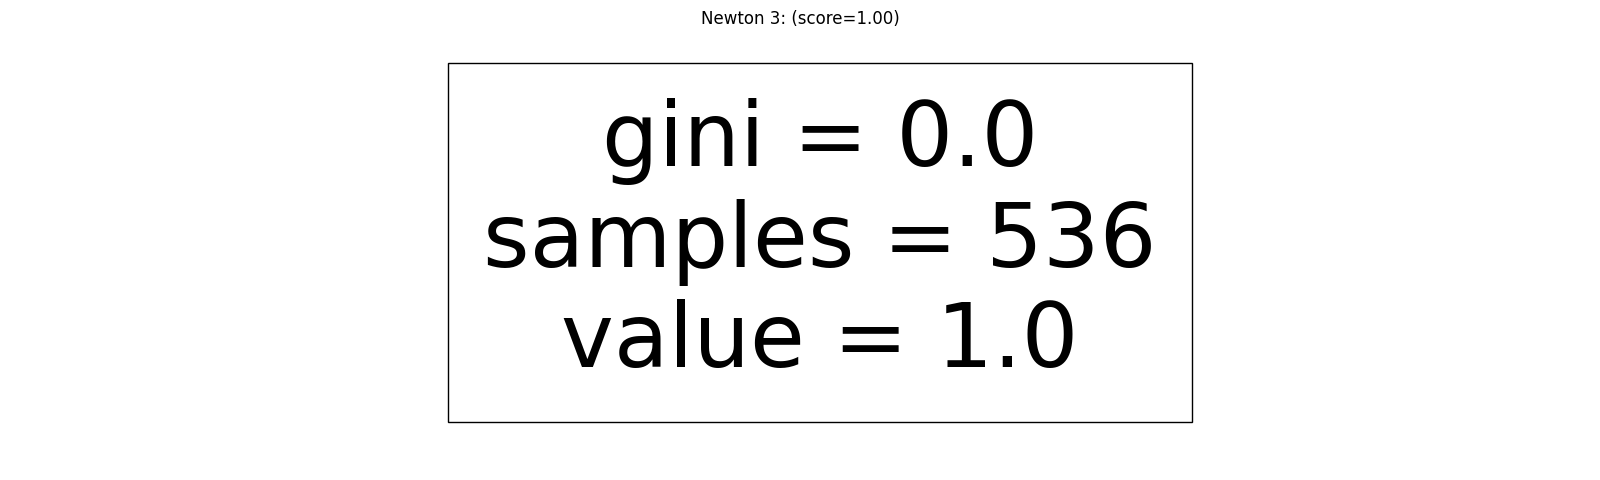

In [28]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


particlesPerCellStdDev: [-inf, 0.044, inf]
particlesPerCellStdDev: [-inf, 0.044, inf]

homogeneity: [-inf, 0.08, 0.082, 0.083, 0.084, 0.085, 0.097, inf]
homogeneity: [-inf, 0.08, 0.082, 0.083, 0.084, 0.085, 0.097, inf]

threadCount: [-inf, 2.5, inf]
threadCount: [-inf, 2.5, inf]

maxParticlesPerCell: [-inf, 19.5, inf]
maxParticlesPerCell: [-inf, 19.5, inf]



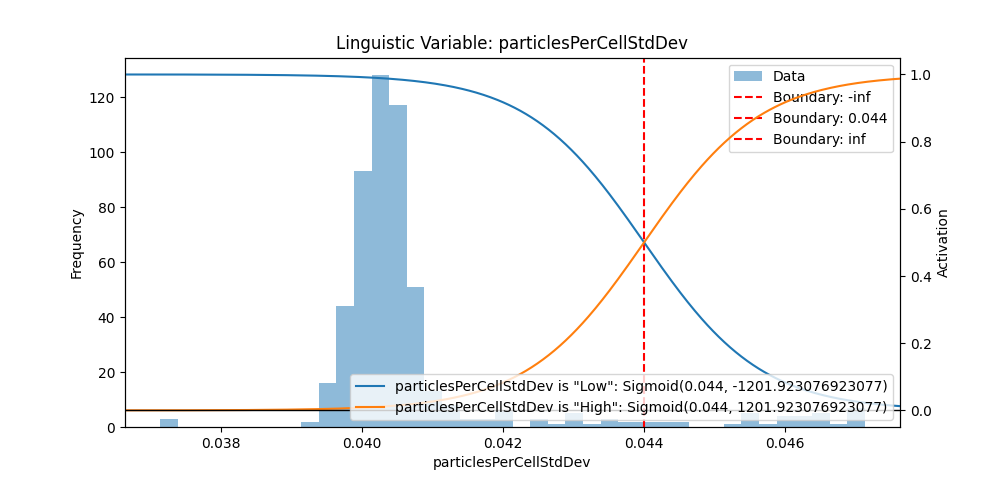

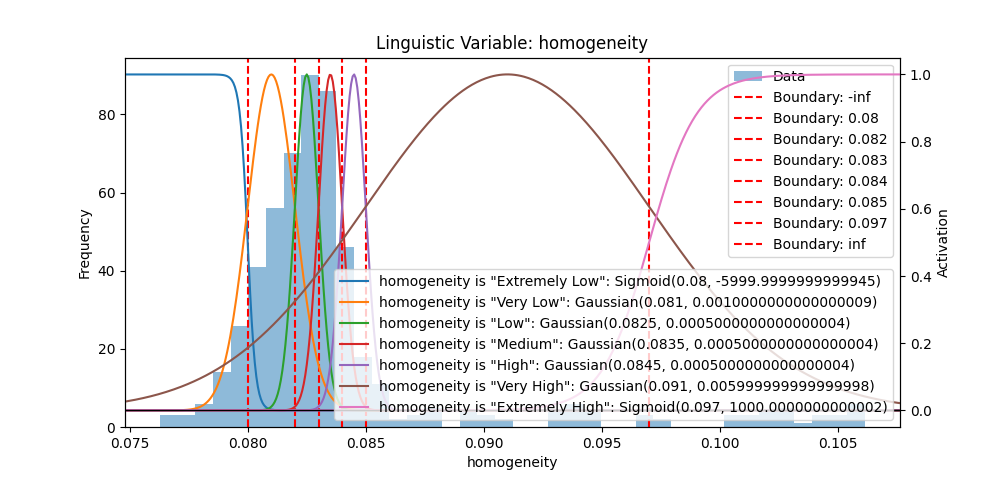

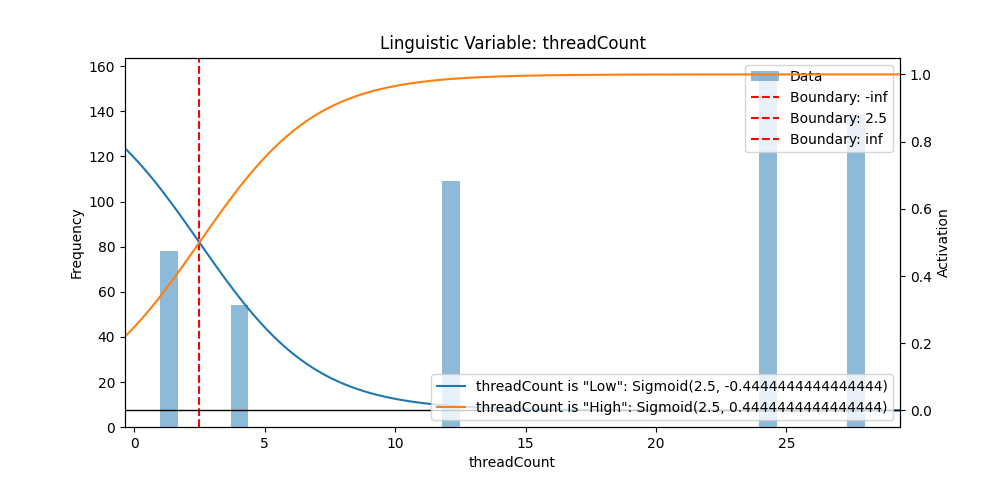

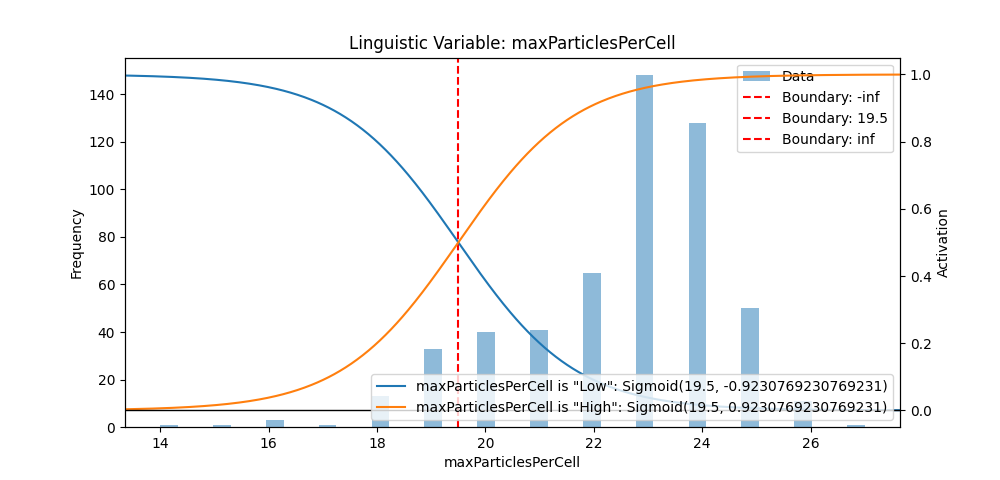

In [29]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


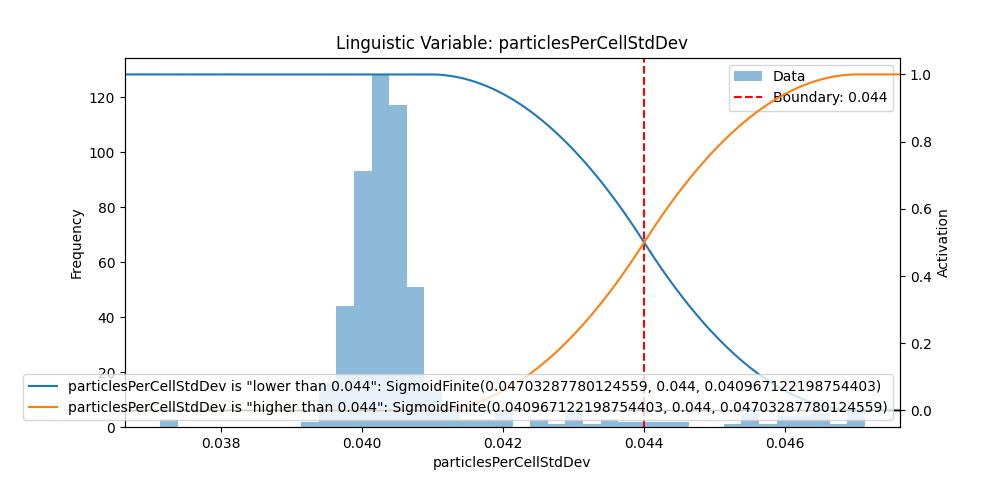

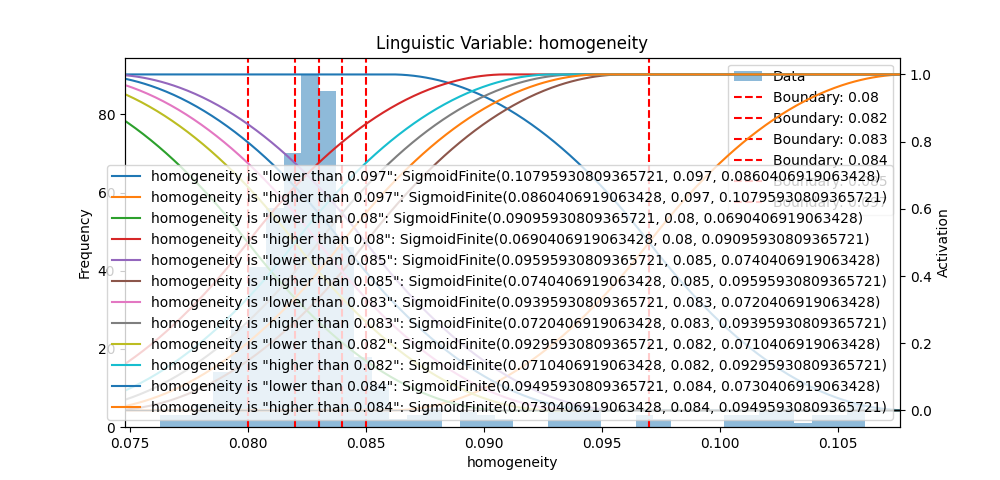

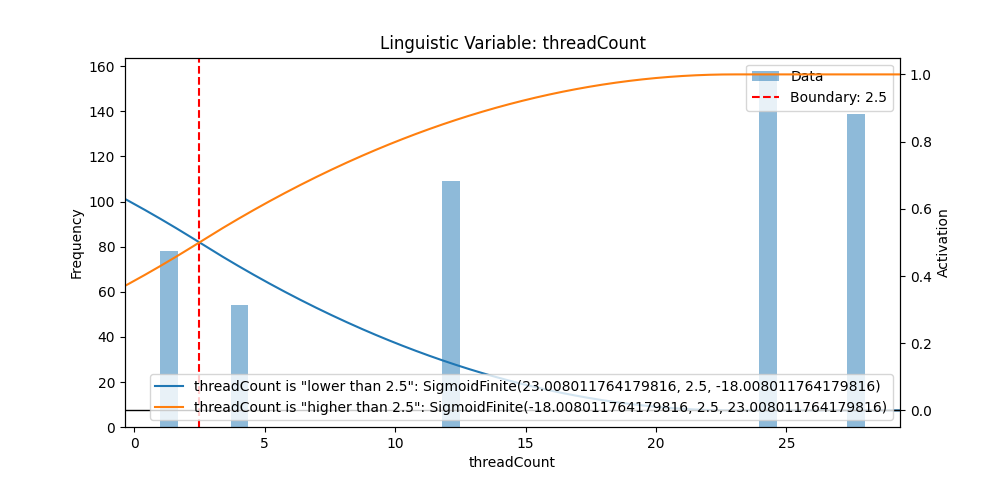

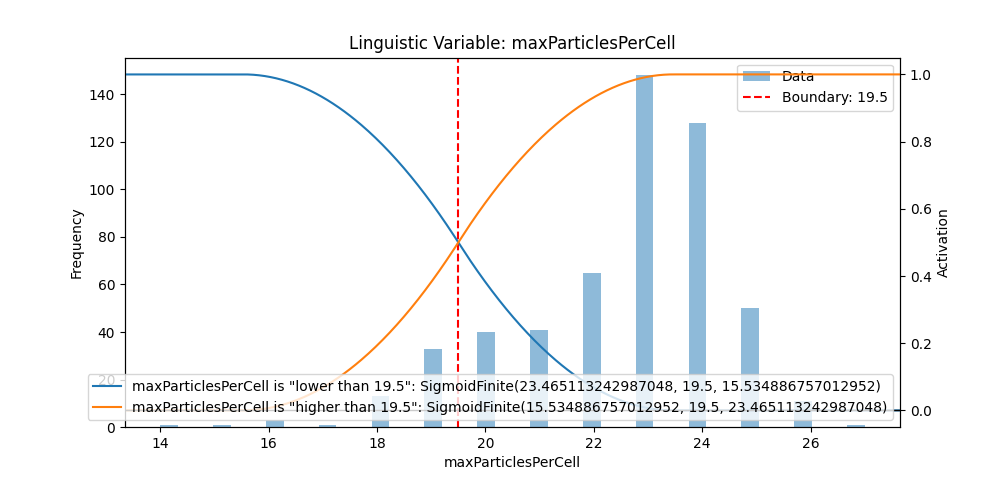

In [30]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data/analysis/cluster/pause-during-examples/../../../../notes/1-Testing/fuzzy-test/python/fuzzy_system.py:380: RuntimeWarning: invalid value encountered in scalar divide
  def peak(self):
/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data/analysis/cluster/pause-during-examples/../../rule_lib/rule_extraction.py:533: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(min(inputs), max(inputs))


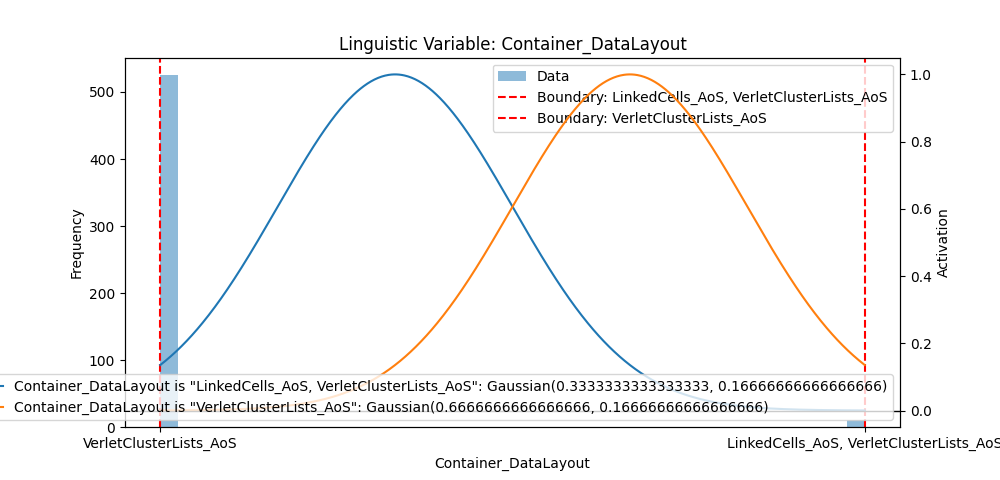

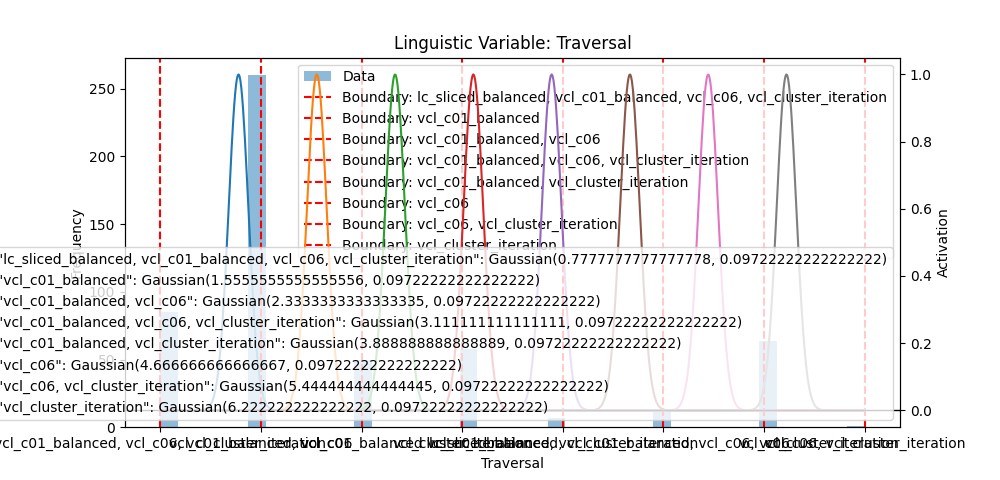

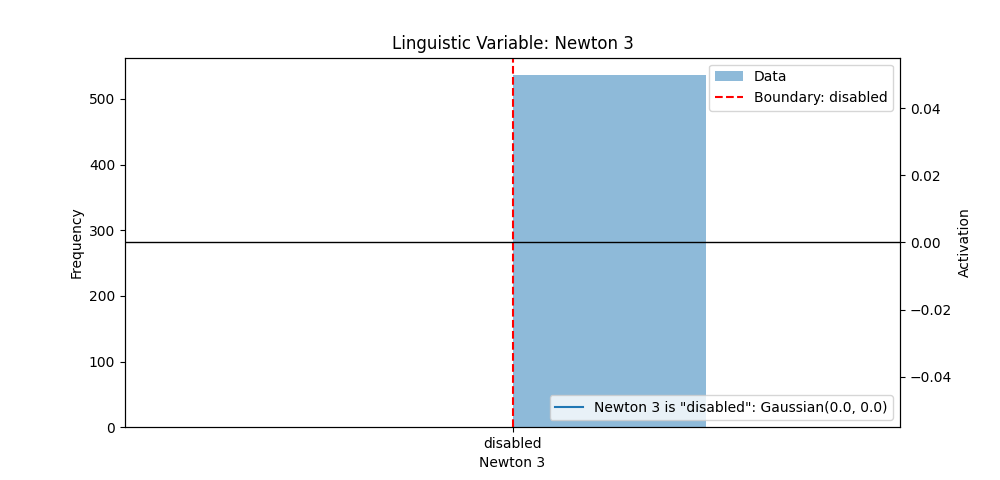

In [34]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [37]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "particlesPerCellStdDev" range: (0.03411012219875441, 0.050159877801245596)
	"Low": Sigmoid(0.044, -1201.923076923077)
	"High": Sigmoid(0.044, 1201.923076923077)

FuzzyVariable: domain: "homogeneity" range: (0.0653356919063428, 0.1170943080936572)
	"Extremely Low": Sigmoid(0.08, -5999.9999999999945)
	"Very Low": Gaussian(0.081, 0.0010000000000000009)
	"Low": Gaussian(0.0825, 0.0005000000000000004)
	"Medium": Gaussian(0.0835, 0.0005000000000000004)
	"High": Gaussian(0.0845, 0.0005000000000000004)
	"Very High": Gaussian(0.091, 0.005999999999999998)
	"Extremely High": Sigmoid(0.097, 1000.0000000000002)

FuzzyVariable: domain: "threadCount" range: (-19.508011764179816, 48.50801176417981)
	"Low": Sigmoid(2.5, -0.4444444444444444)
	"High": Sigmoid(2.5, 0.4444444444444444)

FuzzyVariable: domain: "maxParticlesPerCell" range: (10.034886757012952, 30.965113242987048)
	"Low": Sigmoid(19.5, -0.9230769230769231)
	"High": Sigmoid(19.5, 0.9230769230769231)


FuzzyVariable: dom